In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"durgeshpal","key":"6f6f0f069d7ef1bdb954e0bfea17f6ba"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d durgeshpal/cassavadata

100% 2.37G/2.38G [00:30<00:00, 116MB/s]
100% 2.38G/2.38G [00:30<00:00, 82.6MB/s]


In [7]:
!unzip cassavadata.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/dataset/3/4149005618.jpg  
  inflating: content/dataset/3/4149019611.jpg  
  inflating: content/dataset/3/4149032443.jpg  
  inflating: content/dataset/3/4149062810.jpg  
  inflating: content/dataset/3/414926193.jpg  
  inflating: content/dataset/3/4149442480.jpg  
  inflating: content/dataset/3/4149713617.jpg  
  inflating: content/dataset/3/4149719008.jpg  
  inflating: content/dataset/3/415073532.jpg  
  inflating: content/dataset/3/4151340541.jpg  
  inflating: content/dataset/3/4151371064.jpg  
  inflating: content/dataset/3/4151450216.jpg  
  inflating: content/dataset/3/4151543321.jpg  
  inflating: content/dataset/3/4152202956.jpg  
  inflating: content/dataset/3/4152354751.jpg  
  inflating: content/dataset/3/4152813711.jpg  
  inflating: content/dataset/3/4152969433.jpg  
  inflating: content/dataset/3/4153074724.jpg  
  inflating: content/dataset/3/4153230948.jpg  
  inflating: content/dataset/3/41534658

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/content/dataset", output="test_train_val",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 21390 files [00:10, 2079.70 files/s]


In [11]:
train_dir = "/content/test_train_val/train"
val_dir = "/content/test_train_val/val"
test_dir = "/content/test_train_val/test"

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                          # featurewise_center=True,
                                                          # featurewise_std_normalization=True,
                                                          # rotation_range=90,
                                                          # width_shift_range=0.2,
                                                          # height_shift_range=0.2,
                                                          # horizontal_flip=True,
                                                          # zoom_range=0.2,
                                                          )

In [13]:
train_gen = datagen.flow_from_directory(train_dir,
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                        shuffle=True,
                                                 class_mode = 'categorical')
test_gen= datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                      shuffle=False,
                                            class_mode ='categorical')
val_gen = datagen.flow_from_directory(val_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                      shuffle=True,
                                          class_mode = 'categorical')

Found 17110 images belonging to 5 classes.
Found 2144 images belonging to 5 classes.
Found 2136 images belonging to 5 classes.


In [14]:
# IMG_SIZE = (224, 224)

# train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  shuffle=True,
#                                                                  batch_size=32)


# test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  batch_size=32,
#                                                                 shuffle=False)

# val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  batch_size=32,
#                                                                 shuffle=True)

In [15]:
# Visualizing data
import os 
def visualize_random_images(dataset_type="train", label_type="1"):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

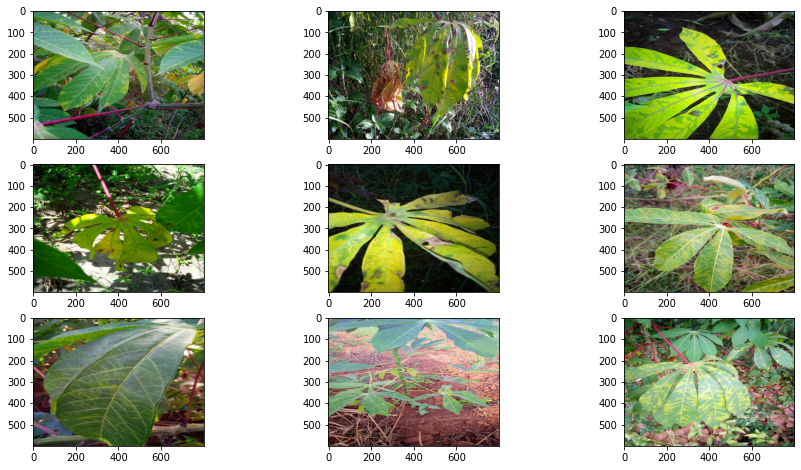

In [16]:
visualize_random_images("/content/test_train_val/train/1/1000723321.jpg")

In [17]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [18]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)

flat_layer = layers.Flatten()(base_layer)

outputs = layers.Dense(5, activation="softmax")(flat_layer)
model = Model(inputs, outputs)

43950080/43941136 [==============================] - 0s 0us/step


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_gen,
                       epochs=20,
                       validation_data=val_gen)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
535/535 [==============================] - 199s 323ms/step - loss: 3.3416 - accuracy: 0.6499 - val_loss: 3.4773 - val_accuracy: 0.6854
Epoch 2/20
535/535 [==============================] - 170s 317ms/step - loss: 2.4691 - accuracy: 0.7413 - val_loss: 3.5410 - val_accuracy: 0.7135
Epoch 3/20
535/535 [==============================] - 168s 314ms/step - loss: 1.8847 - accuracy: 0.7881 - val_loss: 3.9798 - val_accuracy: 0.7079
Epoch 4/20
535/535 [==============================] - 168s 314ms/step - loss: 1.5571 - accuracy: 0.8179 - val_loss: 4.3522 - val_accuracy: 0.7261
Epoch 5/20
535/535 [==============================] - 167s 312ms/step - loss: 1.3083 - accuracy: 0.8437 - val_loss: 4.1664 - val_accuracy: 0.7140
Epoch 6/20
535/535 [==============================] - 167s 311ms/step - loss: 1.2385 - accuracy: 0.8549 - val_loss: 4.9446 - val_accuracy: 0.7013
Epoch 7/20
535/535 [==============================] - 167s 312ms/step - loss: 1.2089 - accuracy: 0.8687 - val_loss: 5.6216 -

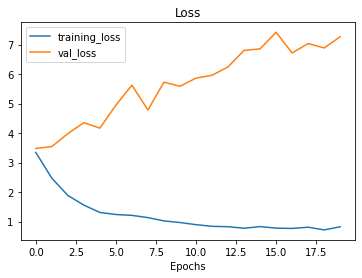

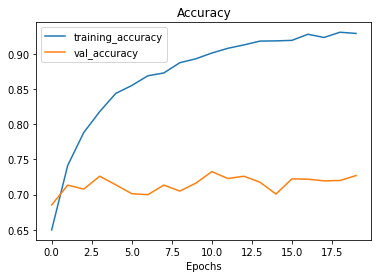

In [20]:
plot_loss_curves(history)

In [22]:
model.evaluate(test_gen)

67/67 [==============================] - 23s 338ms/step - loss: 8.0926 - accuracy: 0.7099


[8.092551231384277, 0.7098880410194397]

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
import numpy as np
print("==============TEST RESULTS============")

num_classes = len(train_gen.class_indices)
test_labels = test_gen.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)
y_true = [i.argmax() for i in test_labels]

predictions = model.predict(test_gen, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
confusion_mtx = confusion_matrix(true_classes, yPredictions) 
y_pred_probabilities=yPredictions
classnames=[]
for classname in test_gen.class_indices:
    classnames.append(classname)

target_names = classnames
print(classification_report(true_classes, yPredictions, target_names=target_names))

# print('roc_auc_score = ' + str(roc_auc_score( true_classes, yPredictions)))

==============TEST RESULTS============
67/67 [==============================] - 19s 281ms/step
              precision    recall  f1-score   support

           0       0.49      0.27      0.35       110
           1       0.49      0.51      0.50       220
           2       0.55      0.30      0.39       239
           3       0.84      0.89      0.87      1317
           4       0.40      0.51      0.45       258

    accuracy                           0.71      2144
   macro avg       0.55      0.50      0.51      2144
weighted avg       0.70      0.71      0.70      2144



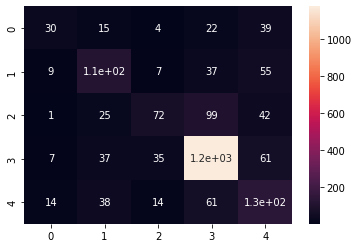

In [25]:
sns.heatmap(confusion_mtx.astype("int"), annot=True)

In [23]:
y_pred = tf.math.round(model.predict(test_gen))
y_true = []
for images, labels in test_gen.unbatch():
  y_true.append(labels.numpy())

AttributeError: ignored

In [ ]:
accuracy_score(y_true, y_pred)

In [ ]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True)